In [11]:
import sys
import warnings

sys.path.append("/workspaces/ood/")
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")
from torch.utils.data import DataLoader
from train import FastflowTrainer
from omegaconf import OmegaConf
import numpy as np
import torch
from anomalib.models.fastflow.model import FastflowModel, FastflowLightning
from tqdm import tqdm
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from albumentations.pytorch import ToTensorV2
import albumentations as A
from ood.draw import draw_score_distr_plot
import matplotlib.pyplot as plt
from anomalib.data.transforms import PreProcessor
from anomalib.data.mvtec import MVTec
from data import FeaturesTrainDataset, FeaturesDatasetOOD

device = torch.device("cuda")
torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [2]:
config = get_configurable_parameters(
    model_config_path="/workspaces/ood/anomalib/anomalib/models/fastflow/config.yaml",
    weight_file="/workspaces/ood/data/test_model_5300_loss.ckpt",
)

In [3]:
# pre_process = PreProcessor(image_size=(config.dataset.image_size[0], config.dataset.image_size[0]))
height = 256
width = 256
pre_process = A.Compose(
    [
        A.Resize(height=height, width=width, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
pre_process_raw = A.Compose(
    [
        A.Resize(height=height, width=width, always_apply=True),
    ]
)

In [4]:
test_data = MVTec(
    root=config.dataset.path,
    category=config.dataset.category,
    split="test",
    pre_process=pre_process,
    task=config.dataset.task,
)
test_data_raw = MVTec(
    root=config.dataset.path,
    category=config.dataset.category,
    split="test",
    pre_process=pre_process_raw,
    task=config.dataset.task,
)
train_data = MVTec(
    root=config.dataset.path,
    category=config.dataset.category,
    split="train",
    pre_process=pre_process,
    task=config.dataset.task,
)

In [5]:
model = get_model(config).to(device)

/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/deprecate/deprecation.py:115: FutureWarning: The `F1` was deprecated since v0.7 in favor of `torchmetrics.classification.f_beta.F1Score`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


CNF coder: 512
CNF coder: 1024
CNF coder: 2048


### Compute scores

In [6]:
in_anomaly_scores = []
out_anomaly_scores = []
for sample in tqdm(test_data):
    image = torch.unsqueeze(torch.tensor(sample["image"]).float().to(device), dim=0)
    label = sample["label"]
    out = model(image)
    anomaly_score = out.detach().cpu().numpy().mean()
    if label == 0:
        in_anomaly_scores.append(anomaly_score)
    else:
        out_anomaly_scores.append(anomaly_score)

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-6-eb7524166cf2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.unsqueeze(torch.tensor(sample['image']).float().to(device), dim=0)
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/workspaces/ood/anomalib/anomalib/models/fastflow/model.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

KeyError: 2000

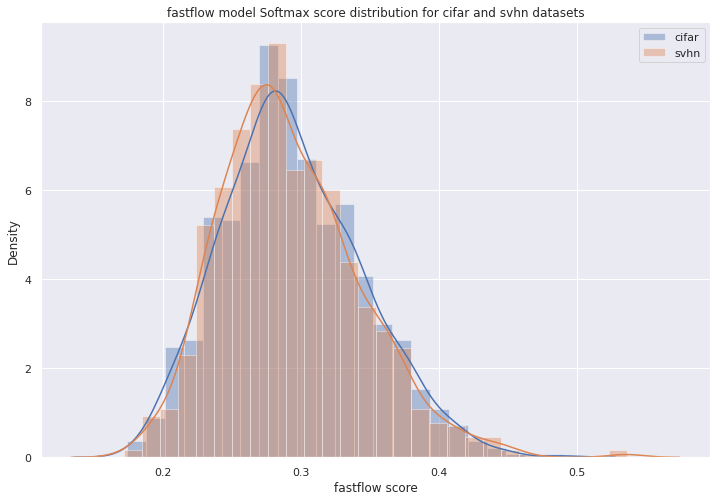

In [12]:
model_name = "fastflow"
draw_score_distr_plot(
    scores_distr={"cifar": in_anomaly_scores, "svhn": out_anomaly_scores},
    score_type="fastflow",
    model_name=model_name,
    in_data_name="cifar",
    out_data_name="svhn",
)

### Vis model pred

<ipython-input-124-1fb451b824c9>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.unsqueeze(torch.tensor(test_data[idx]['image']).float().to(device), dim=0)


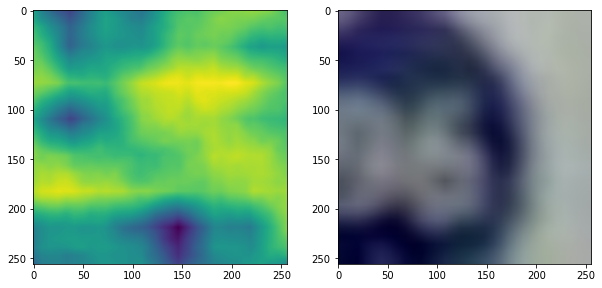

In [124]:
plt.figure(figsize=(10, 15))
idx = 1024
image = torch.unsqueeze(torch.tensor(test_data[idx]["image"]).float().to(device), dim=0)
out = model(image)
ax1 = plt.subplot(121)
ax1.imshow(out.detach().cpu())
ax2 = plt.subplot(122)
# image_to_show = np.moveaxis(test_data[5]['image'], 0, -1)
ax2.imshow(test_data_raw[idx]["image"])